In [128]:
import pandas as pd
import numpy as np
import pyneurovault.api as pnv
import subprocess
import urllib2
import urllib
import nibabel as nib
import os.path
import nilearn
import sklearn.svm
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.metrics
import matplotlib.pyplot as plt
import sklearn.cross_validation

In [2]:
nv = pd.read_csv('neurovault_labeled.csv')

In [3]:
cols = ['id','file', 'collection_id', 'map_type', 'modality','not_mni',
       'cognitive_contrast_cogatlas','cognitive_contrast_cogatlas_id',
       'cognitive_paradigm_cogatlas', 'cognitive_paradigm_cogatlas_id', 
       'contrast_definition', 'contrast_definition_cogatlas']
nv = nv.loc[:,cols]

In [4]:
for col in nv.columns:
    print col
print nv.shape

id
file
collection_id
map_type
modality
not_mni
cognitive_contrast_cogatlas
cognitive_contrast_cogatlas_id
cognitive_paradigm_cogatlas
cognitive_paradigm_cogatlas_id
contrast_definition
contrast_definition_cogatlas
(355, 12)


In [5]:
nv.rename(columns={"id":"image_id"},inplace=True)

In [6]:
nv['not_mni'].value_counts()

False    353
True       2
Name: not_mni, dtype: int64

In [10]:
nv = pnv.download_images("./images/",nv,resample=True,target='/home/kesslerd/repos/cogfusion/nv_tagging/images/space.nii.gz')

In [11]:
template = os.path.join('.','images','resampled','{0:06d}.nii.gz')
nv['handle'] = [nib.load(template.format(path)) for path in nv['image_id'] ]

0      (91, 109, 91)
1      (91, 109, 91)
2      (91, 109, 91)
3      (91, 109, 91)
4      (91, 109, 91)
5      (91, 109, 91)
6      (91, 109, 91)
7      (91, 109, 91)
8      (91, 109, 91)
9      (91, 109, 91)
10     (91, 109, 91)
11     (91, 109, 91)
12     (91, 109, 91)
13     (91, 109, 91)
14     (91, 109, 91)
15     (91, 109, 91)
16     (91, 109, 91)
17     (91, 109, 91)
18     (91, 109, 91)
19     (91, 109, 91)
20     (91, 109, 91)
21     (91, 109, 91)
22     (91, 109, 91)
23     (91, 109, 91)
24     (91, 109, 91)
25     (91, 109, 91)
26     (91, 109, 91)
27     (91, 109, 91)
28     (91, 109, 91)
29     (91, 109, 91)
           ...      
325    (91, 109, 91)
326    (91, 109, 91)
327    (91, 109, 91)
328    (91, 109, 91)
329    (91, 109, 91)
330    (91, 109, 91)
331    (91, 109, 91)
332    (91, 109, 91)
333    (91, 109, 91)
334    (91, 109, 91)
335    (91, 109, 91)
336    (91, 109, 91)
337    (91, 109, 91)
338    (91, 109, 91)
339    (91, 109, 91)
340    (91, 109, 91)
341    (91, 1

In [98]:
nv['shape']=[handle.shape for handle in nv['handle']]
nv['shape'].value_counts()

(91, 109, 91)    355
Name: shape, dtype: int64

In [99]:
X = np.array( [handle.get_data().ravel() for handle in nv['handle']])

In [110]:
y2 = pd.DataFrame(y)

In [111]:
newmask = np.array(y2.isin(["0-back","Math"]))

In [112]:
newmask.squeeze().shape

(301,)

In [113]:
X = X[newmask.squeeze(),:]
y = y[newmask.squeeze()]

/home/kesslerd/repos/cogfusion/env/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 355 but corresponding boolean dimension is 301
  if __name__ == '__main__':


In [118]:
y.value_counts()

0-back    15
Math      13
Name: cognitive_contrast_cogatlas, dtype: int64

In [14]:
X.shape

(355, 902629)

In [15]:
y = nv['cognitive_contrast_cogatlas']

In [119]:
filt = sklearn.feature_selection.SelectKBest(k=1000)

In [120]:
pd.value_counts(y)

0-back    15
Math      13
Name: cognitive_contrast_cogatlas, dtype: int64

In [121]:
clf = sklearn.svm.SVC(kernel='linear',class_weight='balanced')
clf = sklearn.svm.LinearSVC(class_weight={"0-back":1e4,"Math":1e4},C=1)

In [122]:
nv_pipe = sklearn.pipeline.Pipeline([('selector',filt),('classifier',clf)])

In [123]:
nv_pipe.fit(X,y)

/home/kesslerd/repos/cogfusion/env/local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 902626 902627 902628] are constant.
  UserWarning)


Pipeline(steps=[('selector', SelectKBest(k=1000, score_func=<function f_classif at 0x48d79b0>)), ('classifier', LinearSVC(C=1, class_weight={'Math': 10000.0, '0-back': 10000.0}, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0))])

In [124]:
nv_pipe.score(X,y)

0.9642857142857143

In [125]:
pd.value_counts( nv_pipe.predict(X))

0-back    14
Math      14
dtype: int64

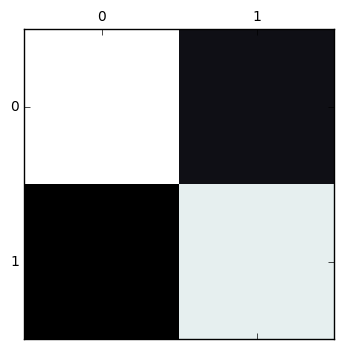

In [127]:
%matplotlib inline
plt.matshow( sklearn.metrics.confusion_matrix(y,nv_pipe.predict(X)), cmap = 'bone')

In [129]:
sklearn.cross_validation.cross_val_score(nv_pipe,X,y)

array([ 0.6       ,  0.33333333,  0.77777778])

In [133]:
mycv = sklearn.cross_validation.StratifiedKFold(y)

In [132]:
sklearn.cross_validation.permutation_test_score(nv_pipe,X,y,cv=mycv)

ValueError: Found array with 0 sample(s) (shape=(0, 902629)) while a minimum of 1 is required.